In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import logging

module_path = os.path.abspath(os.path.join("../../.."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from pathlib import Path

import torch
import torch.utils.data
from torchvision import transforms, datasets
import numpy as np
import matplotlib.pyplot as plt

import pvi
from pvi.models import ClassificationBNNLocalRepam
from pvi.clients import Client
from pvi.servers import SequentialServer
from pvi.distributions import MeanFieldGaussianDistribution, MeanFieldGaussianFactor
from pvi.utils.training_utils import EarlyStopping

In [2]:
data_dir = Path("/Users/terjemildner/Desktop/data")
cache_dir = Path("/Users/terjemildner/Desktop/PVI-main/experiments/femnist")

## Define various functions for splitting data and recording performance metrics.

In [3]:
# Data splitting functions.
def homogeneous_split(data, num_clients=100, seed=78637921):
    # Set numpy's random seed.
    np.random.seed(seed)
    
    perm = np.random.permutation(len(data["x"]))
    client_data = []
    for i in range(num_clients):
        client_idx = perm[i::num_clients]
        client_data.append({"x": data["x"][client_idx], "y": data["y"][client_idx]})
    
    return client_data


# Performance metric function. Why is the batch size 512 when the split gives 600? => Mini batches?
def performance_metrics(client, data, batch_size=512):
    dataset = torch.utils.data.TensorDataset(data["x"], data["y"])
    loader = torch.utils.data.DataLoader(dataset, batch_size=512, shuffle=False)
    
    device = client.config["device"]
    
    if device == "cuda":
        loader.pin_memory = True
        
    preds, mlls = [], []
    for (x_batch, y_batch) in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        pp = client.model_predict(x_batch)
        preds.append(pp.component_distribution.probs.mean(1).cpu())
        mlls.append(pp.log_prob(y_batch).cpu())
        
    mll = torch.cat(mlls).mean()
    preds = torch.cat(preds)
    acc = sum(torch.argmax(preds, dim=-1) == loader.dataset.tensors[1]) / len(
        loader.dataset.tensors[1]
    )
    
    return {"mll": mll, "acc": acc}

## Data preprocessing

In [4]:
transform_train = transforms.Compose([transforms.ToTensor()])
transform_test = transforms.Compose([transforms.ToTensor()])

train_set = datasets.CIFAR10(root=data_dir, train=True, download=True, transform=transform_train)
test_set = datasets.CIFAR10(root=data_dir, train=False, download=True, transform=transform_test)

train_data = {
    "x": torch.tensor(((train_set.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(train_set.targets),
}

test_data = {
    "x": torch.tensor(((test_set.data - 0) / 255).reshape(-1, 3 * 32 * 32), dtype=torch.float32),
    "y": torch.tensor(test_set.targets),
}

Files already downloaded and verified
Files already downloaded and verified


truck


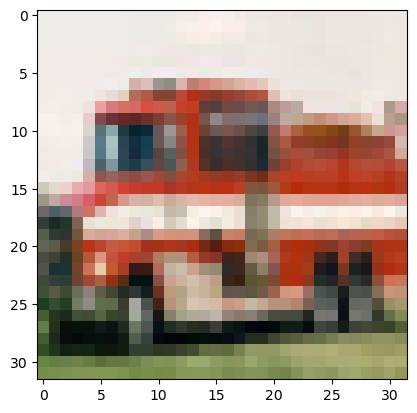

In [5]:
img, lab = train_set[7373]
print(train_set.classes[lab])
plt.imshow(img.permute(1,2,0))
plt.show()

In [6]:
# Get client splits.
client_data = homogeneous_split(train_data, 10, seed=42)


In [7]:
i=1
for client in client_data:
    zero, ones, twos, threes, fours, fives, sixs, sevens, eights, nines = 0,0,0,0,0,0,0,0,0,0
    for label in client["y"]:
        if label == 0:
            zero += 1
        elif label == 1:
            ones += 1
        elif label == 2:
            twos += 1
        elif label == 3:
            threes += 1
        elif label == 4:
            fours += 1
        elif label == 5:
            fives += 1
        elif label == 6:
            sixs += 1
        elif label == 7:
            sevens += 1
        elif label == 8:
            eights += 1
        elif label == 9:
            nines += 1
        else:
            print("Error! Got label: ", label)

    print("Client ", i)
    print(f"Zeros: {zero}")
    print(f"Ones: {ones}")
    print(f"Twos: {twos}")
    print(f"Threes: {threes}")
    print(f"Fours: {fours}")
    print(f"Fives: {fives}")
    print(f"Sixs: {sixs}")
    print(f"Sevens: {sevens}")
    print(f"Eights: {eights}")
    print(f"Nines: {nines}")
    print("=======================================")
    print("=======================================")
    i +=1

Client  1
Zeros: 512
Ones: 499
Twos: 506
Threes: 502
Fours: 497
Fives: 502
Sixs: 468
Sevens: 498
Eights: 512
Nines: 504
Client  2
Zeros: 503
Ones: 556
Twos: 453
Threes: 533
Fours: 488
Fives: 479
Sixs: 464
Sevens: 515
Eights: 531
Nines: 478
Client  3
Zeros: 505
Ones: 484
Twos: 496
Threes: 520
Fours: 494
Fives: 508
Sixs: 515
Sevens: 510
Eights: 483
Nines: 485
Client  4
Zeros: 506
Ones: 504
Twos: 480
Threes: 510
Fours: 513
Fives: 512
Sixs: 511
Sevens: 496
Eights: 446
Nines: 522
Client  5
Zeros: 500
Ones: 515
Twos: 497
Threes: 470
Fours: 504
Fives: 499
Sixs: 496
Sevens: 512
Eights: 511
Nines: 496
Client  6
Zeros: 507
Ones: 463
Twos: 517
Threes: 499
Fours: 491
Fives: 467
Sixs: 513
Sevens: 536
Eights: 510
Nines: 497
Client  7
Zeros: 491
Ones: 497
Twos: 523
Threes: 486
Fours: 495
Fives: 479
Sixs: 484
Sevens: 507
Eights: 505
Nines: 533
Client  8
Zeros: 501
Ones: 471
Twos: 510
Threes: 509
Fours: 497
Fives: 534
Sixs: 509
Sevens: 450
Eights: 515
Nines: 504
Client  9
Zeros: 461
Ones: 506
Twos: 520

In [8]:
client_data[0]["x"][0].dtype

torch.float32

## Define configuration for server and clients

In [9]:
model_config = {
    "input_dim": 3072,
    "latent_dim": 512,
    "output_dim": 10,
    "num_layers": 1,
    "num_predictive_samples": 100,
    "prior_var": 1.0,
}

client_config = {
    "damping_factor": 1.0,
    "optimiser": "Adam",
    "optimiser_params": {"lr": 5e-4},
    "sigma_optimiser_params": {"lr": 5e-4},
    "early_stopping": EarlyStopping(50, score_name="elbo", stash_model=True),
    "performance_metrics": performance_metrics,
    "batch_size": 512,
    "epochs": 1000,
    "print_epochs": np.inf,
    "num_elbo_samples": 10,
    "valid_factors": False,
    "device": "cpu",
    "init_var": 1e-3,
    "verbose": True,
}

server_config = {
    **client_config,
    #100
    "max_iterations": 100,
}

## Set up model etc.

In [10]:
device = server_config["device"]

model = ClassificationBNNLocalRepam(config=model_config)

# Initial parameters.
init_q_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device).uniform_(-0.1, 0.1),
    "scale": torch.ones(size=(model.num_parameters,)).to(device) 
    * client_config["init_var"] ** 0.5,
}

prior_std_params = {
    "loc": torch.zeros(size=(model.num_parameters,)).to(device),
    "scale": model_config["prior_var"] ** 0.5 
    * torch.ones(size=(model.num_parameters,)).to(device),
}

init_factor_nat_params = {
    "np1": torch.zeros(model.num_parameters).to(device),
    "np2": torch.zeros(model.num_parameters).to(device),
}

p = MeanFieldGaussianDistribution(
    std_params=prior_std_params, is_trainable=False
)
init_q = MeanFieldGaussianDistribution(
    std_params=init_q_std_params, is_trainable=False
)

clients = []
size_training = 0
for i in range(10):
    data_i = client_data[i]
    size_training += len(data_i["x"])
    t_i = MeanFieldGaussianFactor(nat_params=init_factor_nat_params)
    clients.append(
        Client(
            data=data_i,
            model=model,
            t=t_i,
            config=client_config,
            val_data=test_data
        )
    )    
server = SequentialServer(model=model, p=p, clients=clients, config=server_config, init_q=init_q, data=train_data, val_data=test_data)

## Run PVI! 1 Hidden Layer

In [11]:
i = 0
while not server.should_stop():
    server.tick()

    # Obtain performance metrics.
    metrics = server.log["performance_metrics"][-1]
    print("Iterations: {}.".format(i))
    print("Time taken: {:.3f}.".format(metrics["time"]))
    print(
      "Test mll: {:.3f}. Test acc: {:.3f}.".format(
          metrics["val_mll"], metrics["val_acc"]
      )
    )
    print(
      "Train mll: {:.3f}. Train acc: {:.3f}.\n".format(
          metrics["train_mll"], metrics["train_acc"]
      )
    )
    i += 1

0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 0.
Time taken: 3416.007.
Test mll: -1.646. Test acc: 0.413.
Train mll: -1.634. Train acc: 0.420.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 1.
Time taken: 5739.566.
Test mll: -1.652. Test acc: 0.422.
Train mll: -1.641. Train acc: 0.424.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 2.
Time taken: 7064.730.
Test mll: -1.642. Test acc: 0.425.
Train mll: -1.633. Train acc: 0.427.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 3.
Time taken: 8158.470.
Test mll: -1.638. Test acc: 0.430.
Train mll: -1.630. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 4.
Time taken: 11212.062.
Test mll: -1.636. Test acc: 0.428.
Train mll: -1.631. Train acc: 0.429.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 5.
Time taken: 12831.553.
Test mll: -1.635. Test acc: 0.428.
Train mll: -1.630. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 6.
Time taken: 13655.825.
Test mll: -1.637. Test acc: 0.427.
Train mll: -1.631. Train acc: 0.427.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 7.
Time taken: 14533.356.
Test mll: -1.635. Test acc: 0.425.
Train mll: -1.630. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 8.
Time taken: 15526.796.
Test mll: -1.635. Test acc: 0.426.
Train mll: -1.629. Train acc: 0.428.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 9.
Time taken: 16436.306.
Test mll: -1.635. Test acc: 0.431.
Train mll: -1.629. Train acc: 0.433.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 10.
Time taken: 17255.555.
Test mll: -1.635. Test acc: 0.429.
Train mll: -1.628. Train acc: 0.428.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 11.
Time taken: 18158.942.
Test mll: -1.635. Test acc: 0.430.
Train mll: -1.631. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 12.
Time taken: 19173.286.
Test mll: -1.636. Test acc: 0.430.
Train mll: -1.630. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 13.
Time taken: 20355.025.
Test mll: -1.635. Test acc: 0.429.
Train mll: -1.629. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 14.
Time taken: 21361.924.
Test mll: -1.636. Test acc: 0.430.
Train mll: -1.630. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 15.
Time taken: 22342.600.
Test mll: -1.634. Test acc: 0.431.
Train mll: -1.630. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 16.
Time taken: 23401.244.
Test mll: -1.634. Test acc: 0.433.
Train mll: -1.630. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 17.
Time taken: 24132.641.
Test mll: -1.634. Test acc: 0.431.
Train mll: -1.628. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 18.
Time taken: 24911.734.
Test mll: -1.637. Test acc: 0.428.
Train mll: -1.631. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 19.
Time taken: 25920.983.
Test mll: -1.636. Test acc: 0.431.
Train mll: -1.630. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 20.
Time taken: 26685.632.
Test mll: -1.634. Test acc: 0.426.
Train mll: -1.630. Train acc: 0.428.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 21.
Time taken: 27588.331.
Test mll: -1.636. Test acc: 0.431.
Train mll: -1.630. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 22.
Time taken: 28423.986.
Test mll: -1.636. Test acc: 0.429.
Train mll: -1.630. Train acc: 0.429.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 23.
Time taken: 29237.049.
Test mll: -1.634. Test acc: 0.434.
Train mll: -1.629. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 24.
Time taken: 30012.786.
Test mll: -1.635. Test acc: 0.428.
Train mll: -1.630. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 25.
Time taken: 30770.945.
Test mll: -1.634. Test acc: 0.428.
Train mll: -1.629. Train acc: 0.434.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 26.
Time taken: 31595.332.
Test mll: -1.633. Test acc: 0.432.
Train mll: -1.628. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 27.
Time taken: 32565.407.
Test mll: -1.635. Test acc: 0.431.
Train mll: -1.629. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 28.
Time taken: 33412.511.
Test mll: -1.633. Test acc: 0.432.
Train mll: -1.630. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 29.
Time taken: 34509.204.
Test mll: -1.632. Test acc: 0.432.
Train mll: -1.626. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 30.
Time taken: 37920.173.
Test mll: -1.635. Test acc: 0.432.
Train mll: -1.629. Train acc: 0.433.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 31.
Time taken: 39522.980.
Test mll: -1.635. Test acc: 0.433.
Train mll: -1.629. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 32.
Time taken: 41219.669.
Test mll: -1.633. Test acc: 0.436.
Train mll: -1.629. Train acc: 0.434.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 33.
Time taken: 43246.992.
Test mll: -1.633. Test acc: 0.429.
Train mll: -1.629. Train acc: 0.429.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 34.
Time taken: 45296.284.
Test mll: -1.631. Test acc: 0.434.
Train mll: -1.625. Train acc: 0.434.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 35.
Time taken: 47023.875.
Test mll: -1.634. Test acc: 0.426.
Train mll: -1.628. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 36.
Time taken: 48700.523.
Test mll: -1.633. Test acc: 0.432.
Train mll: -1.627. Train acc: 0.433.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 37.
Time taken: 50245.780.
Test mll: -1.634. Test acc: 0.432.
Train mll: -1.629. Train acc: 0.431.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 38.
Time taken: 52083.464.
Test mll: -1.636. Test acc: 0.429.
Train mll: -1.629. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 39.
Time taken: 53564.650.
Test mll: -1.633. Test acc: 0.429.
Train mll: -1.626. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 40.
Time taken: 55004.861.
Test mll: -1.633. Test acc: 0.430.
Train mll: -1.626. Train acc: 0.432.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 41.
Time taken: 56322.755.
Test mll: -1.632. Test acc: 0.434.
Train mll: -1.626. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 42.
Time taken: 57885.314.
Test mll: -1.632. Test acc: 0.431.
Train mll: -1.626. Train acc: 0.433.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Iterations: 43.
Time taken: 59378.848.
Test mll: -1.635. Test acc: 0.429.
Train mll: -1.629. Train acc: 0.430.



0it [00:00, ?it/s]

Epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

KeyboardInterrupt: 

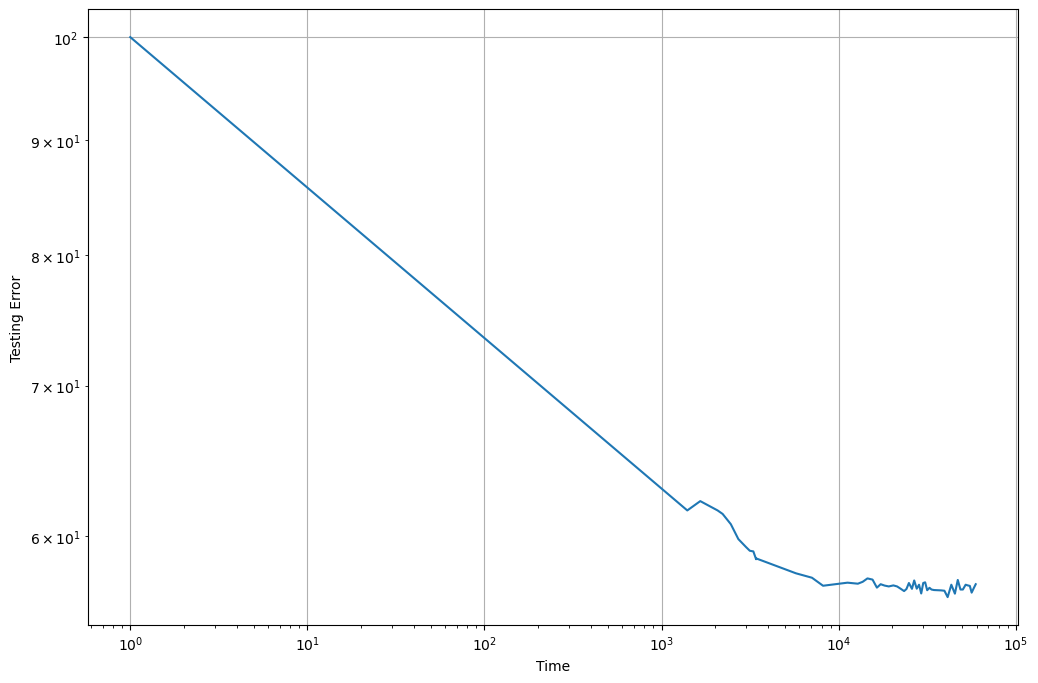

In [12]:
train_acc = []
val_acc = []
times = []
train_acc.append(100.0)
val_acc.append(100.0)
times.append(1.0)
for metrics in server.log["performance_metrics"]:
    train_acc.append(100-metrics["train_acc"]*100)
    val_acc.append(100-metrics["val_acc"]*100)
    times.append(metrics["time"])
plt.figure(figsize=(12,8))
plt.xscale("log")
plt.yscale("log")
plt.plot(times, val_acc)
plt.xlabel("Time")
plt.ylabel("Testing Error")
plt.grid(visible=True)
#plt.savefig("PVI on MNIST, lr=0.002.png")

plt.show()